In [7]:
#FUNCION PARA LEER EL ARCIHVO DEL DATA SET
import json

def load_hateval_json(file_path):
    texts = []
    labels = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data = json.loads(line.strip())
                texts.append(data["text"])
                labels.append(int(data["klass"]))
            except Exception as e:
                print(f"Error leyendo línea: {e}")
    
    return texts, labels

In [8]:
#Paso 2 — Cargar los datos de entrenamiento y prueba
X_train_es, y_train_es = load_hateval_json("hateval_es_train_spanish.json")
X_test_es, y_test_es = load_hateval_json("hateval_es_test_spanish.json")

In [9]:
#Comprobar las cargas
print("ES train:", len(X_train_es))
print("ES test:", len(X_test_es))

ES train: 4500
ES test: 500


In [10]:
# Agregar estos imports al inicio
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import unicodedata
import re  # También necesitamos re para las expresiones regulares

# Descargar stopwords si es necesario
# nltk.download('stopwords')

# Inicializar recursos de NLP
stemmer = SnowballStemmer('spanish')
stop_words_es = set(stopwords.words('spanish'))

# Tus constantes para normalización
PUNCTUACTION = ";:,.\\-\"'/"
SYMBOLS = "()[]¿?¡!{}~<>|"
NUMBERS = "0123456789"
SKIP_SYMBOLS = set(PUNCTUACTION + SYMBOLS)

def only_normalizar_texto(input_str, punct=False, accents=False, num=False, max_dup=2, lowercase=True):
    """
    Tu función de normalización (la que ya tenías)
    """
    nfkd_f = unicodedata.normalize('NFKD', input_str)
    n_str = []
    c_prev = ''
    cc_prev = 0
    for c in nfkd_f:
        if not num:
            if c in NUMBERS:
                continue
        if not punct:
            if c in SKIP_SYMBOLS:
                continue
        if not accents and unicodedata.combining(c):
            continue
        if c_prev == c:
            cc_prev += 1
            if cc_prev >= max_dup:
                continue
        else:
            cc_prev = 0
        n_str.append(c)
        c_prev = c
    texto = unicodedata.normalize('NFKD', "".join(n_str))
    texto = re.sub(r'(\s)+', r' ', texto.strip(), flags=re.IGNORECASE)
    
    if lowercase:
        texto = texto.lower()
    
    return texto

def normalizar_txt_sin_StopWords(texto):
    """
    Normaliza + elimina stopwords
    """
    texto_normalizado = only_normalizar_texto(
        texto, punct=False, accents=False, num=False, max_dup=2, lowercase=True
    )
    
    if not texto_normalizado:
        return ""
    
    palabras = texto_normalizado.split()
    palabras_filtradas = [palabra for palabra in palabras if palabra not in stop_words_es]
    
    return ' '.join(palabras_filtradas)

def normalizar_txt_sin_StopWords_mas_stemming(texto):
    """
    Normaliza + elimina stopwords + aplica stemming
    """
    texto_sin_stopwords = normalizar_txt_sin_StopWords(texto)
    
    if not texto_sin_stopwords:
        return ""
    
    palabras = texto_sin_stopwords.split()
    palabras_stemmed = [stemmer.stem(palabra) for palabra in palabras]
    
    return ' '.join(palabras_stemmed)

def mi_preprocesamiento(tipo_procesamiento):
    """
    Función dispatcher para seleccionar preprocesamiento
    """
    procesadores = {
        'only_normalizar_texto': lambda x: only_normalizar_texto(
            x, punct=False, accents=False, num=False, max_dup=2, lowercase=True
        ),
        'normalizar_txt_sin_StopWords': normalizar_txt_sin_StopWords,
        'normalizar_txt_sin_StopWords_mas_stemming': normalizar_txt_sin_StopWords_mas_stemming
    }
    
    return procesadores[tipo_procesamiento]

In [8]:
# Probar con algunos ejemplos
print("=== PRUEBA DE PREPROCESAMIENTO ===")
ejemplo_tweet = X_train_es[0] if X_train_es else "¡Hola! Este es un EJEMPLO con números 123 y ACENTOS: áéíóú"

print(f"Original: {ejemplo_tweet}")
print(f"Solo normalizar: {mi_preprocesamiento('only_normalizar_texto')(ejemplo_tweet)}")
print(f"Sin stopwords: {mi_preprocesamiento('normalizar_txt_sin_StopWords')(ejemplo_tweet)}")
print(f"Con stemming: {mi_preprocesamiento('normalizar_txt_sin_StopWords_mas_stemming')(ejemplo_tweet)}")

=== PRUEBA DE PREPROCESAMIENTO ===
Original: Easyjet quiere duplicar el número de mujeres piloto' Verás tú para aparcar el avión.. http://t.co/46NuLkm09x
Solo normalizar: easyjet quiere duplicar el numero de mujeres piloto veras tu para aparcar el avion httptconulkmx
Sin stopwords: easyjet quiere duplicar numero mujeres piloto veras aparcar avion httptconulkmx
Con stemming: easyjet quier duplic numer mujer pilot ver aparc avion httptconulkmx


In [13]:
#CLASE MLP_TODO.PY Y FUNCIONES AUXILIARES
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from time import time

# ====================================================
# Funciones para activación y  su derivada
# ====================================================

# Función de activación sigmoide
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivada de la sigmoide
def sigmoid_derivative(x):
    # return sigmoid(x) * (1 - sigmoid(x))
    return x * (1 - x)

# ====================================================
# Funciones para manejo de la semilla
# ====================================================

# Establece la semilla para la generación de números aleatorios
def seed(random_state=33):
    np.random.seed(random_state)
    random.seed(random_state)

# ====================================================
# Funciones para inicialización y normalización
# ====================================================

# Inicialización Xavier
def xavier_initialization(input_size, output_size): 
    return np.random.randn(input_size, output_size) * np.sqrt(1 / input_size)
# Inicialización normal
def normal_initialization(input_size, output_size):
    return np.random.randn(input_size, output_size)
# Normalización Z-score
def zscore_normalization(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_norm = (X - mean) / std
    return X_norm

#Función para crear minibatches
def create_minibatches(X, y, batch_size):
    """
    Genera los lotes de datos (batchs) de acuerdo al parámetro batch_size de forma aleatoria para el procesamiento. 
    """
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)  # Mezcla los índices aleatoriamente
    X_shuffled, y_shuffled = X[indices], y[indices]  # Reordena X e y según los índices aleatorios
    
    # Divide los datos en minibatches
    for X_batch, y_batch in zip(np.array_split(X_shuffled, np.ceil(n_samples / batch_size)), 
                                np.array_split(y_shuffled, np.ceil(n_samples / batch_size))):
        yield X_batch, y_batch

    
class MLP_TODO:
    def __init__(self, num_entradas, num_neuronas_ocultas, num_salidas, epochs, batch_size=128, learning_rate=0.2, normalizacion="none",inicializacion="xavier",random_state=42):

        # ====================================================
        # Inicialización general del modelo
        # ====================================================

        # 🔹 NUEVO: Usar el parámetro random_state recibido para controlar la semilla
        seed(33)
        self.random_state = random_state  # 🔹 NUEVO: guardar la semilla para usarla también en create_minibatches

        # Definir la tasa de aprendizaje
        self.learning_rate = learning_rate
        # Definir el número de épocas
        self.epochs = epochs
        # Definir el tamaño del batch de procesamiento
        self.batch_size = batch_size
        # Definir el tipo de normalización
        self.normalizacion = normalizacion
        # Definir el tipo de inicialización
        self.inicializacion = inicializacion
        # definir las 
        self.num_neuronas_ocultas = num_neuronas_ocultas

        # Inicialización de pesos y bias
        self.W1 = self.inicializar_pesos(num_entradas, self.num_neuronas_ocultas) # Pesos entre capa de entrada y capa oculta
        self.b1 = np.zeros((1, self.num_neuronas_ocultas))   # Bias de la capa oculta
        self.W2 = self.inicializar_pesos(self.num_neuronas_ocultas,num_salidas)  # Pesos entre capa oculta y capa de salida
        self.b2 = np.zeros((1, num_salidas)) # Bias de la capa de salida

        # Historial de errores
        self.errores_history = []
        # Historial de accuracy
        self.accuracy_history = []

    # ====================================================
    # Funciones para forward, backward, update, predict y train
    # ====================================================

    def forward(self, X):
        #implementar el forward pass
        #----------------------------------------------
        # 1. Propagación hacia adelante (Forward pass)
        #----------------------------------------------
        # Calcular la suma ponderada Z (z_c1) para la capa oculta 
        self.X = X
        self.z_c1 = X@self.W1 + self.b1
        #Calcular la activación de la capa oculta usando la función sigmoide
        self.a_c1 = sigmoid(self.z_c1)  # Activación capa oculta
        #Calcular la suma ponderada Z (z_c2)  para la capa de salida 
        self.z_c2  = self.a_c1 @ self.W2 + self.b2
        #Calcular la activación de la capa de salida usando la función sigmoide
        y_pred = sigmoid(self.z_c2)  # Activación capa salida
        return y_pred
    

    def loss_function_MSE(self, y_pred, y):
        #----------------------------------------------
        # 2. Cálculo del error con MSE
        #----------------------------------------------
        #Calcular el error cuadrático medio (MSE)
        self.y_pred = y_pred
        self.y = y
        error = 0.5 * np.mean((y_pred - y) ** 2)
        return error
    

    def backward(self):
        #implementar el backward pass
        # calcular los gradientes para la arquitectura de la figura anterior
        #----------------------------------------------
        # 3. Propagación hacia atrás (Backward pass)
        #----------------------------------------------
        
        #----------------------------------------------
        # Gradiente de la salida
        #----------------------------------------------
        #Calcular la derivada del error con respecto a la salida y
        dE_dy_pred = (self.y_pred - self.y)  # Derivada del error respecto a la predicción con  N ejemplos
        #Calcular la derivada de la activación de la salida con respecto a z_c2 
        d_y_pred_d_zc2 = sigmoid_derivative(self.y_pred)
        #Calcular delta de la capa de salida
        delta_c2 = dE_dy_pred * d_y_pred_d_zc2  # (N, 1)

        #----------------------------------------------
        # Gradiente en la capa oculta
        #----------------------------------------------
        # calcular la derivada de las suma ponderada respecto a las activaciones de la capa 1
        d_zc2_d_a_c1 = self.W2  
        #Propagar el error hacia la capa oculta, calcular deltas de la capa 1
        delta_c1 = delta_c2 @ d_zc2_d_a_c1.T * sigmoid_derivative(self.a_c1)  

        #calcula el gradiente de la función de error respecto a los pesos de la capa 2
        self.dE_dW2 = self.a_c1.T @ delta_c2
        self.dE_db2 = np.sum(delta_c2, axis=0, keepdims=True)
        self.dE_dW1 = self.X.T @ delta_c1 
        self.dE_db1 = np.sum(delta_c1, axis=0, keepdims=True) 


    def update(self):  # Ejecución de la actualización de paramámetros
        #implementar la actualización de los pesos y el bias
        #----------------------------------------------
        # Actualización de pesos de la capa de salida
        #---------------------------------------------- 
        #Actualizar los pesos y bias de la capa de salida
        self.W2 = self.W2 - self.dE_dW2 * self.learning_rate
        self.b2 = self.b2 - self.dE_db2 * self.learning_rate
        #----------------------------------------------
        # Actuailzación de pesos de la capa oculta
        #----------------------------------------------
        #calcula el gradiente de la función de error respecto a los pesos de la capa 1
        self.W1 = self.W1 - self.dE_dW1 * self.learning_rate
        self.b1 = self.b1 - self.dE_db1 * self.learning_rate

    def predict(self, X):  # Predecir la categoría para datos nuevos
        # TODO: implementar la predicción 
        y_pred = self.forward(X)
        # Obtener la clase para el clasificador binario
        y_pred = np.where(y_pred >= 0.5, 1, 0)
        return y_pred

    def train(self, X, Y, paciencia=10):
        """
        Entrenamiento con parada temprana
        """
        # Normalizar los datos
        X = self.normalize(X)
        
        # Variables para parada temprana
        mejor_error = float('inf')
        epocas_sin_mejora = 0
        
        for epoch in range(self.epochs):
            num_batch = 0
            epoch_error = 0
            
            # Procesar cada batch
            for X_batch, y_batch in create_minibatches(X, Y, self.batch_size):
                y_pred = self.forward(X_batch)
                error = self.loss_function_MSE(y_pred, y_batch)
                epoch_error += error    
                self.backward()
                self.update()
                num_batch += 1
            
            # Error promedio de la época
            error_promedio = epoch_error / num_batch
            self.errores_history.append(error_promedio)
            
            # Calcular Accuracy
            acc_epoch = self.accuracy(X, Y)
            self.accuracy_history.append(acc_epoch)
            
            # Verificar si hay mejora
            if error_promedio < mejor_error:
                mejor_error = error_promedio
                epocas_sin_mejora = 0
            else:
                epocas_sin_mejora += 1
            
            # Parar si no hay mejora después de 'paciencia' épocas
            if epocas_sin_mejora >= paciencia:
                print(f"🛑 Parada temprana en época {epoch}. Error: {error_promedio:.6f}")
                break
            
            # Imprimir progreso cada 50 épocas
            if epoch % 50 == 0:
                print(f"Época {epoch:3d} | Error: {error_promedio:.6f} | Accuracy: {acc_epoch:.4f}")
        
        print(f"✅ Entrenamiento finalizado. Mejor error: {mejor_error:.6f}")

    def evaluar(self, X, y):
        """
        Evalúa el desempeño del modelo en un conjunto de prueba.
        Muestra todas las predicciones junto con las salidas esperadas en columnas paralelas.
        Calcula la precisión total.
        """
        # Normalizar los datos de entrada con la misma técnica usada en entrenamiento
        X = self.normalize(X)

        # Obtener las predicciones
        y_pred = self.predict(X)

        # Combinar esperadas y predicciones en columnas paralelas
        resultados = np.column_stack((y, y_pred))
        
        # Mostrar resultados
        print("\n🔍 Evaluación del modelo (esperada | predicha):")
        for idx, (esperada, predicha) in enumerate(resultados):
            print(f"{idx+1:02d}: {esperada} | {predicha}")

        # Calcular precisión global
        accuracy = np.mean(y_pred == y)
        print(f"\n✅ Precisión del modelo: {accuracy * 100:.2f}%")

        return accuracy


    
    # ====================================================
    # Funciones para inicialización, normalización y accuracy
    # ====================================================
    # Normalización de los datos
    def normalize(self, X):
        if self.normalizacion == "z-score":
            return zscore_normalization(X)  # 🔹 Llamada a la función existente
        else:  # sin normalizar
            return X
        
    # Inicialización de los pesos  
    def inicializar_pesos(self, tamaño_entrada, tamaño_salida):
        if self.inicializacion == "xavier":
            return xavier_initialization(tamaño_entrada, tamaño_salida)
        elif self.inicializacion == "normal":
            return normal_initialization(tamaño_entrada, tamaño_salida)
        else:
            raise ValueError("Tipo de inicialización no soportado")
    # Cálculo de accuracy    
    def accuracy(self, X, y):
        y_pred = self.predict(X)
        acc = np.mean(y_pred == y)  # compara predicciones con valores reales
        return acc
    
    # ====================================================
    # Funciones para graficar Error, Acurery y ambas
    # ====================================================
    
    # Gráfica del error despues del entrenamiento
    def plot_error(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.errores_history, label="Error MSE", linewidth=2)
        plt.xlabel("Épocas")
        plt.ylabel("Error cuadrático medio (MSE)")
        #Título dinámico con configuración
        plt.title(f"Entrenamiento MLP - Capacas ocultas: {self.num_neuronas_ocultas}, Inicializacion: {self.inicializacion}, Normalización: {self.normalizacion}, "
                f"LR: {self.learning_rate}, Batch_size: {self.batch_size},Funcion de activacion: Sigmoid, Épocas: {self.epochs}")
        plt.legend()
        plt.grid(True)
        plt.show()
  
    

In [17]:
#FUNCIONES PARA LEER COMBINACINES Y GUARDAR RESULTADOS
import pandas as pd
import ast
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from time import time

def leer_combinaciones_desde_csv(archivo_csv):
    """
    Lee las combinaciones desde un archivo CSV
    """
    df = pd.read_csv(archivo_csv)
    combinaciones = []
    
    for _, row in df.iterrows():
        config = {
            'neuronas': int(row['neuronas']),
            'inicializacion': row['inicializacion'],
            'pesado': row['pesado'],
            'representacion': ast.literal_eval(row['representacion']),
            'preprocesamiento': row['preprocesamiento'],
            'learning_rate': float(row['learning_rate']),
            'batch_size': int(row['batch_size']),
            'epocas': int(row['epocas'])
        }
        combinaciones.append(config)
    
    print(f"✅ Leídas {len(combinaciones)} combinaciones desde {archivo_csv}")
    return combinaciones

def guardar_resultados_csv(resultados, archivo_salida="resultados_experimentos.csv"):
    """Guarda los resultados en un archivo CSV incluyendo épocas ejecutadas"""
    datos_csv = []
    
    for resultado in resultados:
        config = resultado['config']
        fila = {
            'Neuronas': config['neuronas'],
            'Inicialización': config['inicializacion'],
            'Normalización': 'none',
            'Learning rate': config['learning_rate'],
            'Batch size': config['batch_size'],
            'Pesado_termino': config['pesado'],
            'Representacion_terminos': str(config['representacion']),
            'ProcesamientosTXT': config['preprocesamiento'],
            'Epocas_ejecutadas': resultado.get('epocas_ejecutadas', config['epocas']),  # NUEVO
            'Error final': resultado['final_loss'],
            'Tiempo (s)': resultado['training_time'],
            'Accuracy(macro)': resultado['accuracy'],
            'F1-score(macro)': resultado['f1_score'],
            'Presicion(macro)': resultado['precision'],
            'Recall(macro)': resultado['recall']
        }
        datos_csv.append(fila)
    
    # Crear DataFrame y guardar
    df_resultados = pd.DataFrame(datos_csv)
    df_resultados.to_csv(archivo_salida, index=False, encoding='utf-8')
    
    print(f"✅ Resultados guardados en: {archivo_salida}")
    print(f"📊 Total de experimentos guardados: {len(datos_csv)}")
    
    return df_resultados

In [15]:
#FUNCION PARA EJECUTAR EXPERIMETO COMPLETO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
def ejecutar_experimento_completo(config, X_train, y_train, X_test, y_test):
    """
    Ejecuta un experimento completo con una configuración específica
    y retorna todas las métricas solicitadas
    """
    print(f"\n Ejecutando experimento:")
    print(f"   Preprocesamiento: {config['preprocesamiento']}")
    print(f"   Pesado: {config['pesado']}")
    print(f"   Representación: {config['representacion']}")
    print(f"   Neuronas: {config['neuronas']}, LR: {config['learning_rate']}, Batch: {config['batch_size']}")
    
    # 1. Crear vectorizador según la configuración
    if config['pesado'] == 'TF':
        Vectorizador = CountVectorizer
    else:  # TF-IDF
        Vectorizador = TfidfVectorizer
    
    vectorizador = Vectorizador(
        analyzer="word",
        preprocessor=mi_preprocesamiento(config['preprocesamiento']),
        ngram_range=config['representacion'],
        
    )
    
    try:
        # 2. Vectorizar datos
        X_train_vec = vectorizador.fit_transform(X_train).toarray()
        X_test_vec = vectorizador.transform(X_test).toarray()
        
        print(f"   Dimensiones: {X_train_vec.shape} -> {X_test_vec.shape}")
        
        # 3. Preparar parámetros para MLP_TODO
        n_input = X_train_vec.shape[1]
        n_hidden = config['neuronas']
        n_output = 1
        
        # Mapear inicialización
        init_map = {'Normal': 'normal', 'Xavier': 'xavier'}
        
        # 4. Crear y entrenar modelo
        model = MLP_TODO(
            num_entradas=n_input,
            num_neuronas_ocultas=n_hidden,
            num_salidas=n_output,
            epochs=config['epocas'],
            batch_size=config['batch_size'],
            learning_rate=config['learning_rate'],
            normalizacion="none",
            inicializacion=init_map[config['inicializacion']],
            random_state=42
        )
        
        # 5. Entrenar modelo
        start_time = time()
        model.train(X_train_vec, np.array(y_train).reshape(-1, 1), paciencia=10)
        training_time = time() - start_time

        # === AGREGAR ESTAS 2 LÍNEAS ===
        # Obtener épocas realmente ejecutadas
        epocas_ejecutadas = len(model.errores_history)

        
        # 6. Evaluar
        y_pred = model.predict(X_test_vec)
        
        # 7. Calcular todas las métricas solicitadas
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)
        final_loss = model.errores_history[-1] if model.errores_history else 0
        
        # 8. Preparar resultados
        results = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'accuracy': accuracy,
            'final_loss': final_loss,
            'training_time': training_time,
            'epocas_ejecutadas': epocas_ejecutadas,
            'config': config
        }
        
        print(f"   Resultados - F1: {f1:.4f}, Accuracy: {accuracy:.4f}, Time: {training_time:.2f}s")
        
        return results
        
    except Exception as e:
        print(f"   Error en experimento: {e}")
        return None

In [40]:
#CODIGO PARA PROBAR UNA COMBINACION
combinaciones = leer_combinaciones_desde_csv("combinaciones_experimentos_128.csv")
combinaciones[10]

✅ Leídas 20 combinaciones desde combinaciones_experimentos_128.csv


{'neuronas': 128,
 'inicializacion': 'Xavier',
 'pesado': 'TF',
 'representacion': (1, 2),
 'preprocesamiento': 'only_normalizar_texto',
 'learning_rate': 0.01,
 'batch_size': 16,
 'epocas': 500}

In [28]:
#CODIGO PARA PROBAR UNA COMBINACION
combinaciones = leer_combinaciones_desde_csv("combinaciones_experimentos_128.csv")

if combinaciones:
    # Tomar la primera combinación para probar
    config_csv = combinaciones[10]
    #config_csv['epocas'] = 100
    print(f"🧪 PROBANDO CON COMBINACIÓN DEL CSV:")
    print(f"Configuración: {config_csv}")
    
    # MODIFICACIÓN: Cambiar el nombre de la función en ejecutar_experimento_completo
    # para que use train con early stopping
    
    # Ejecutar experimento con esta configuración
    resultado_csv = ejecutar_experimento_completo(
        config_csv,
        X_train_es,
        y_train_es, 
        X_test_es,
        y_test_es
    )
    
    if resultado_csv:
        # Guardar este resultado
        resultados_lista = [resultado_csv]
        df_guardado = guardar_resultados_csv(resultados_lista, "prueba_csv_mejor_experimento_all_feutures_500epocas_128.csv")
        print("✅ ¡Prueba con CSV completada!")

✅ Leídas 20 combinaciones desde combinaciones_experimentos_128.csv
🧪 PROBANDO CON COMBINACIÓN DEL CSV:
Configuración: {'neuronas': 128, 'inicializacion': 'Xavier', 'pesado': 'TF', 'representacion': (1, 2), 'preprocesamiento': 'only_normalizar_texto', 'learning_rate': 0.01, 'batch_size': 16, 'epocas': 500}

 Ejecutando experimento:
   Preprocesamiento: only_normalizar_texto
   Pesado: TF
   Representación: (1, 2)
   Neuronas: 128, LR: 0.01, Batch: 16
   Dimensiones: (4500, 71171) -> (500, 71171)
Época   0 | Error: 0.121147 | Accuracy: 0.5862
Época  50 | Error: 0.006242 | Accuracy: 0.9956
Época 100 | Error: 0.001395 | Accuracy: 0.9998
Época 150 | Error: 0.000619 | Accuracy: 1.0000
Época 200 | Error: 0.000377 | Accuracy: 1.0000
Época 250 | Error: 0.000265 | Accuracy: 1.0000
Época 300 | Error: 0.000202 | Accuracy: 1.0000
Época 350 | Error: 0.000162 | Accuracy: 1.0000
Época 400 | Error: 0.000134 | Accuracy: 1.0000
Época 450 | Error: 0.000114 | Accuracy: 1.0000
✅ Entrenamiento finalizado. Me

In [ ]:
# CODIGO PARA AUTOMATIZAR LOS EXPERIMENTOS 
combinaciones = leer_combinaciones_desde_csv("combinaciones_experimentos_64.csv")

if combinaciones:
    # Cambiar todas las épocas a 100
    for config in combinaciones:
        config['epocas'] = 100
    
    print(f"Iniciando {len(combinaciones)} experimentos automáticos")
    
    # Lista para guardar todos los resultados
    todos_resultados = []
    
    # Recorrer cada configuración
    for i, config in enumerate(combinaciones, 1):
        print(f"\n EXPERIMENTO {i}/{len(combinaciones)}")
        print(f"Configuración: {config}")
        
        # Ejecutar experimento
        resultado = ejecutar_experimento_completo(
            config,
            X_train_es,
            y_train_es, 
            X_test_es,
            y_test_es
        )
        
        if resultado:
            # Agregar a la lista de resultados
            todos_resultados.append(resultado)
            
            # Guardar resultados después de cada experimento
            guardar_resultados_csv(todos_resultados, "resultados_automaticos_1024.csv")
            print(f"Experimento {i} guardado - Épocas: {resultado['epocas_ejecutadas']}")
        else:
            print(f"Experimento {i} falló")
    
    print(f"\n¡TODOS LOS EXPERIMENTOS COMPLETADOS!")
    print(f"Total: {len(todos_resultados)}/{len(combinaciones)} exitosos")

✅ Leídas 20 combinaciones desde combinaciones_experimentos_1024.csv
🎯 Iniciando 20 experimentos automáticos

🔬 EXPERIMENTO 1/20
Configuración: {'neuronas': 1024, 'inicializacion': 'Normal', 'pesado': 'TF', 'representacion': (2, 2), 'preprocesamiento': 'normalizar_txt_sin_StopWords', 'learning_rate': 0.01, 'batch_size': 32, 'epocas': 100}

🔬 Ejecutando experimento:
   Preprocesamiento: normalizar_txt_sin_StopWords
   Pesado: TF
   Representación: (2, 2)
   Neuronas: 1024, LR: 0.01, Batch: 32
   Dimensiones: (4500, 10000) -> (500, 10000)
Época   0 | Error: 0.214257 | Accuracy: 0.5820
Época  50 | Error: 0.139876 | Accuracy: 0.7198
✅ Entrenamiento finalizado. Mejor error: 0.115313
   ✅ Resultados - F1: 0.5912, Accuracy: 0.6460, Time: 1486.70s
✅ Resultados guardados en: resultados_automaticos_1024.csv
📊 Total de experimentos guardados: 1
✅ Experimento 1 guardado - Épocas: 100

🔬 EXPERIMENTO 2/20
Configuración: {'neuronas': 1024, 'inicializacion': 'Xavier', 'pesado': 'TF-IDF', 'representacio

In [19]:
import pandas as pd

# Leer resultados y ordenar
df = pd.read_csv("resultados_automaticos_1024.csv")

# Ordenar por F1-score y luego Accuracy
df_ordenado = df.sort_values(['F1-score(macro)', 'Accuracy(macro)'], ascending=[False, False])

# Guardar en el mismo archivo
df_ordenado.to_csv("resultados_espanñol_ordenados_1024.csv", index=False)

print(f"✅ Resultados ordenados y guardados en: resultados_español_ordenados_1024.csv")
print(f"📊 Mejor F1-score: {df_ordenado.iloc[0]['F1-score(macro)']:.4f}")

✅ Resultados ordenados y guardados en: resultados_español_ordenados_1024.csv
📊 Mejor F1-score: 0.7354


In [36]:
import pandas as pd

# Lista de tus archivos
archivos = [
    "resultados_automaticos_64.csv",
    "resultados_automaticos_128.csv", 
    "resultados_automaticos_256.csv",
    "resultados_automaticos_512.csv",
    "resultados_automaticos_1024.csv"
]

# Leer y combinar todos los archivos
dataframes = []
for archivo in archivos:
    df = pd.read_csv(archivo)
    dataframes.append(df)

# Combinar todo en un solo DataFrame
df_final = pd.concat(dataframes, ignore_index=True)

# Guardar el archivo consolidado
df_final.to_csv('todos_experimentos_español.csv', index=False)

print("✅ ¡Listo! Todos los archivos se consolidaron en 'todos_experimentos_consolidados.csv'")
print(f"📊 Total de experimentos: {len(df_final)}")

✅ ¡Listo! Todos los archivos se consolidaron en 'todos_experimentos_consolidados.csv'
📊 Total de experimentos: 100


In [1]:
import pandas as pd

# Leer resultados y ordenar
df = pd.read_csv("mejores_5combinaciones_español.csv")

# Ordenar por F1-score y luego Accuracy
df_ordenado = df.sort_values(['F1-score(macro)', 'Accuracy(macro)'], ascending=[False, False])

# Guardar en el mismo archivo
df_ordenado.to_csv("mejores_5combinaciones_español_ordenados_F1_Acc.csv", index=False)

print(f"✅ Resultados ordenados y guardados en: resultados_español_ordenados_1024.csv")
print(f"📊 Mejor F1-score: {df_ordenado.iloc[0]['F1-score(macro)']:.4f}")

✅ Resultados ordenados y guardados en: resultados_español_ordenados_1024.csv
📊 Mejor F1-score: 0.8067


In [43]:
# CODIGO PARA AUTOMATIZAR LOS EXPERIMENTOS 
combinaciones = leer_combinaciones_desde_csv("combinaciones_experimentos_128.csv")

if combinaciones:
    # Cambiar todas las épocas a 100
    for config in combinaciones:
        config['epocas'] = 100
    
    print(f"🎯 Iniciando {len(combinaciones)} experimentos automáticos")
    
    # Lista para guardar todos los resultados
    todos_resultados = []
    
    # Recorrer cada configuración
    for i, config in enumerate(combinaciones, 1):
        print(f"\n🔬 EXPERIMENTO {i}/{len(combinaciones)}")
        print(f"Configuración: {config}")
        
        # Ejecutar experimento
        resultado = ejecutar_experimento_completo(
            config,
            X_train_es,
            y_train_es, 
            X_test_es,
            y_test_es
        )
        
        if resultado:
            # Agregar a la lista de resultados
            todos_resultados.append(resultado)
            
            # Guardar resultados después de cada experimento
            guardar_resultados_csv(todos_resultados, "resultados_automaticos_1024.csv")
            print(f"✅ Experimento {i} guardado - Épocas: {resultado['epocas_ejecutadas']}")
        else:
            print(f"❌ Experimento {i} falló")
    
    print(f"\n🎉 ¡TODOS LOS EXPERIMENTOS COMPLETADOS!")
    print(f"📊 Total: {len(todos_resultados)}/{len(combinaciones)} exitosos")

✅ Leídas 20 combinaciones desde combinaciones_experimentos_128.csv
🎯 Iniciando 20 experimentos automáticos

🔬 EXPERIMENTO 1/20
Configuración: {'neuronas': 128, 'inicializacion': 'Normal', 'pesado': 'TF', 'representacion': (1, 2), 'preprocesamiento': 'only_normalizar_texto', 'learning_rate': 0.1, 'batch_size': 16, 'epocas': 100}

 Ejecutando experimento:
   Preprocesamiento: only_normalizar_texto
   Pesado: TF
   Representación: (1, 2)
   Neuronas: 128, LR: 0.1, Batch: 16
   Dimensiones: (4500, 71171) -> (500, 71171)


KeyboardInterrupt: 

📊 Columnas encontradas en el CSV: ['Neuronas', 'Inicialización', 'Normalización', 'Learning rate', 'Batch size', 'Pesado_termino', 'Representacion_terminos', 'ProcesamientosTXT', 'Epocas_ejecutadas', 'Error final', 'Tiempo (s)', 'Accuracy(macro)', 'F1-score(macro)', 'Presicion(macro)', 'Recall(macro)']
✅ Leídas 5 combinaciones desde mejores_5combinaciones_español_ordenados_F1_Acc.csv
🚀 Ejecutando las 5 mejores combinaciones...

🔬 Ejecutando 1° Combinación:
   Preprocesamiento: only_normalizar_texto
   Pesado: TF
   Representación: (1, 2)
   Neuronas: 128, LR: 0.01, Batch: 16
   Dimensiones: (4500, 10000) -> (500, 10000)
Época   0 | Error: 0.121717 | Accuracy: 0.5873
Época  50 | Error: 0.021647 | Accuracy: 0.9696
✅ Entrenamiento finalizado. Mejor error: 0.007937
   ✅ Resultados - F1: 0.8067, Accuracy: 0.8100, Time: 377.67s

🔬 Ejecutando 2° Combinación:
   Preprocesamiento: normalizar_txt_sin_StopWords
   Pesado: TF
   Representación: (1, 2)
   Neuronas: 64, LR: 0.01, Batch: 16
   Dimens

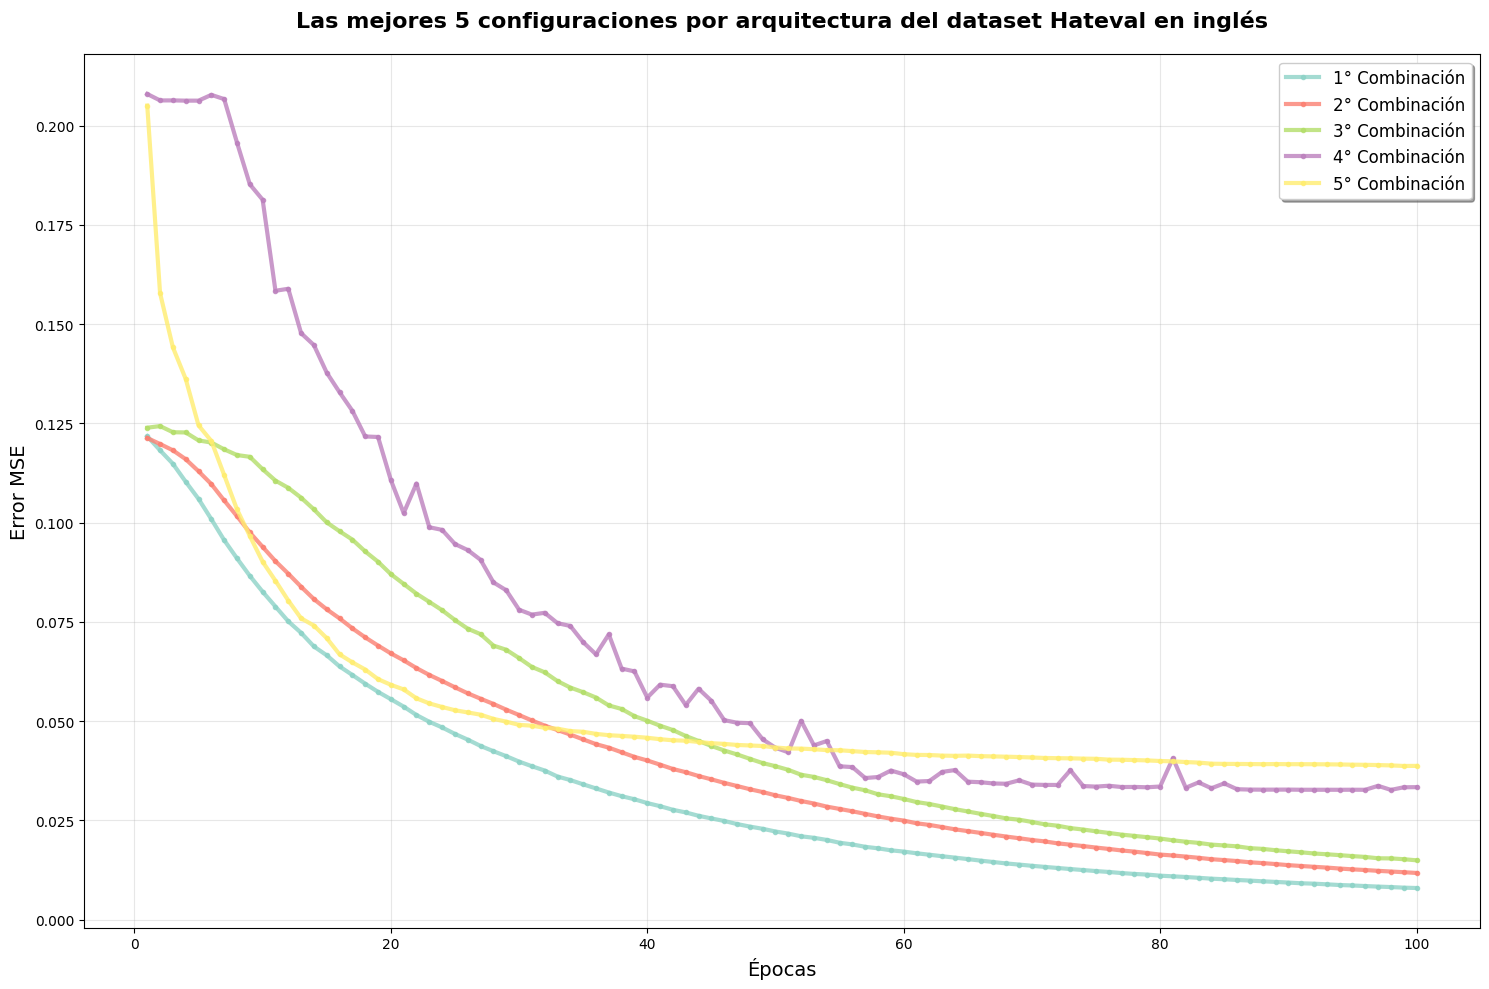


📋 CONFIGURACIONES DE LAS 5 COMBINACIONES:

1° COMBINACIÓN:
   • Neuronas: 128
   • Inicialización: Xavier
   • Learning rate: 0.01
   • Batch size: 16
   • Pesado: TF
   • Representación: (1, 2)
   • Preprocesamiento: only_normalizar_texto
   • Error final: 0.0079
   • F1-score: 0.8067
   • Accuracy: 0.8100

2° COMBINACIÓN:
   • Neuronas: 64
   • Inicialización: Xavier
   • Learning rate: 0.01
   • Batch size: 16
   • Pesado: TF
   • Representación: (1, 2)
   • Preprocesamiento: normalizar_txt_sin_StopWords
   • Error final: 0.0117
   • F1-score: 0.7853
   • Accuracy: 0.7880

3° COMBINACIÓN:
   • Neuronas: 256
   • Inicialización: Xavier
   • Learning rate: 0.01
   • Batch size: 16
   • Pesado: TF
   • Representación: (2, 2)
   • Preprocesamiento: only_normalizar_texto
   • Error final: 0.0149
   • F1-score: 0.7641
   • Accuracy: 0.7700

4° COMBINACIÓN:
   • Neuronas: 1024
   • Inicialización: Normal
   • Learning rate: 0.1
   • Batch size: 32
   • Pesado: TF-IDF
   • Representación: 

In [23]:
# FUNCIÓN PARA GRAFICAR MÚLTIPLES ERRORES EN UNA MISMA FIGURA CON ETIQUETAS SIMPLIFICADAS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def leer_combinaciones_desde_csv(archivo_csv):
    """
    Lee las combinaciones de parámetros desde un archivo CSV
    """
    try:
        df = pd.read_csv(archivo_csv)
        print(f"📊 Columnas encontradas en el CSV: {df.columns.tolist()}")
        
        combinaciones = []
        
        for _, row in df.iterrows():
            config = {
                'neuronas': int(row['Neuronas']),
                'inicializacion': row['Inicialización'],
                'pesado': row['Pesado_termino'],
                'representacion': ast.literal_eval(row['Representacion_terminos']),
                'preprocesamiento': row['ProcesamientosTXT'],
                'learning_rate': float(row['Learning rate']),
                'batch_size': int(row['Batch size']),
                'epocas': int(row['Epocas_ejecutadas'])
            }
            combinaciones.append(config)
        
        print(f"✅ Leídas {len(combinaciones)} combinaciones desde {archivo_csv}")
        return combinaciones
        
    except Exception as e:
        print(f"❌ Error leyendo CSV {archivo_csv}: {e}")
        return None

def plot_errors_combinados(df_resultados, titulo_general):
    """
    Grafica todas las curvas de error en una misma figura con etiquetas simplificadas
    """
    plt.figure(figsize=(15, 10))
    colores = plt.cm.Set3(np.linspace(0, 1, len(df_resultados)))  # Colores más distintivos
    
    for idx, (_, fila) in enumerate(df_resultados.iterrows()):
        # Etiqueta simplificada: 1° Combinación, 2° Combinación, etc.
        etiqueta = f"{idx+1}° Combinación"
        
        errores = fila['Errores historial']
        plt.plot(range(1, len(errores) + 1), errores, 
                lw=3, color=colores[idx], label=etiqueta, alpha=0.8, marker='o', markersize=3)
    
    plt.xlabel("Épocas", fontsize=14)
    plt.ylabel("Error MSE", fontsize=14)
    plt.title(titulo_general, fontsize=16, fontweight='bold', pad=20)
    plt.legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# FUNCIÓN PARA CREAR TABLA DE CONFIGURACIONES
def crear_tabla_configuraciones(df_combinado):
    """
    Crea una tabla con las configuraciones de cada combinación
    """
    print("\n📋 CONFIGURACIONES DE LAS 5 COMBINACIONES:")
    print("="*80)
    
    for idx, (_, fila) in enumerate(df_combinado.iterrows()):
        print(f"\n{idx+1}° COMBINACIÓN:")
        print(f"   • Neuronas: {fila['Neuronas']}")
        print(f"   • Inicialización: {fila['Inicialización']}")
        print(f"   • Learning rate: {fila['Learning rate']}")
        print(f"   • Batch size: {fila['Batch size']}")
        print(f"   • Pesado: {fila['Pesado']}")
        print(f"   • Representación: {fila['Representacion']}")
        print(f"   • Preprocesamiento: {fila['Preprocesamiento']}")
        print(f"   • Error final: {fila['Error final']:.4f}")
        print(f"   • F1-score: {fila['F1_score']:.4f}")
        print(f"   • Accuracy: {fila['Accuracy']:.4f}")

# FUNCIÓN MODIFICADA PARA EJECUTAR EXPERIMENTOS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from time import time
import numpy as np

def ejecutar_experimentos_combinados(combinaciones, X_train, y_train, X_test, y_test, plot_individual=False, plot_combinado=True):
    """
    Ejecuta múltiples experimentos y los grafica combinados en una figura
    """
    todos_resultados = []
    df_combinado = pd.DataFrame()
    
    for i, config in enumerate(combinaciones):
        print(f"\n🔬 Ejecutando {i+1}° Combinación:")
        print(f"   Preprocesamiento: {config['preprocesamiento']}")
        print(f"   Pesado: {config['pesado']}")
        print(f"   Representación: {config['representacion']}")
        print(f"   Neuronas: {config['neuronas']}, LR: {config['learning_rate']}, Batch: {config['batch_size']}")
        
        # 1. Crear vectorizador según la configuración
        if config['pesado'] == 'TF':
            Vectorizador = CountVectorizer
        else:  # TF-IDF
            Vectorizador = TfidfVectorizer
        
        vectorizador = Vectorizador(
            analyzer="word",
            preprocessor=mi_preprocesamiento(config['preprocesamiento']),
            ngram_range=config['representacion'],
            max_features=10000
        )
        
        try:
            # 2. Vectorizar datos
            X_train_vec = vectorizador.fit_transform(X_train).toarray()
            X_test_vec = vectorizador.transform(X_test).toarray()
            
            print(f"   Dimensiones: {X_train_vec.shape} -> {X_test_vec.shape}")
            
            # 3. Preparar parámetros para MLP_TODO
            n_input = X_train_vec.shape[1]
            n_hidden = config['neuronas']
            n_output = 1
            
            # Mapear inicialización
            init_map = {'Normal': 'normal', 'Xavier': 'xavier'}
            
            # 4. Crear y entrenar modelo
            model = MLP_TODO(
                num_entradas=n_input,
                num_neuronas_ocultas=n_hidden,
                num_salidas=n_output,
                epochs=config['epocas'],
                batch_size=config['batch_size'],
                learning_rate=config['learning_rate'],
                normalizacion="none",
                inicializacion=init_map[config['inicializacion']],
                random_state=42
            )
            
            # 5. Entrenar modelo
            start_time = time()
            model.train(X_train_vec, np.array(y_train).reshape(-1, 1), paciencia=10)
            training_time = time() - start_time

            # Obtener épocas realmente ejecutadas
            epocas_ejecutadas = len(model.errores_history)
            
            # 6. Evaluar
            y_pred = model.predict(X_test_vec)
            
            # 7. Calcular métricas
            precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
            recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
            accuracy = accuracy_score(y_test, y_pred)
            final_loss = model.errores_history[-1] if model.errores_history else 0
            
            # 8. Preparar resultados
            results = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'accuracy': accuracy,
                'final_loss': final_loss,
                'training_time': training_time,
                'epocas_ejecutadas': epocas_ejecutadas,
                'config': config,
                'errores_history': model.errores_history.copy()
            }
            
            todos_resultados.append(results)
            
            # 9. Agregar al DataFrame combinado
            nueva_fila = pd.DataFrame([{
                'Neuronas': config['neuronas'],
                'Inicialización': config['inicializacion'],
                'Normalización': 'none',
                'Learning rate': config['learning_rate'],
                'Batch size': config['batch_size'],
                'Error final': final_loss,
                'Errores historial': model.errores_history,
                'Preprocesamiento': config['preprocesamiento'],
                'Pesado': config['pesado'],
                'Representacion': str(config['representacion']),
                'F1_score': f1,
                'Accuracy': accuracy,
                'Combinacion': f"{i+1}° Combinación"
            }])
            
            df_combinado = pd.concat([df_combinado, nueva_fila], ignore_index=True)
            
            print(f"   ✅ Resultados - F1: {f1:.4f}, Accuracy: {accuracy:.4f}, Time: {training_time:.2f}s")
            
            # 10. Gráfica individual si se solicita
            if plot_individual and model.errores_history:
                titulo_individual = f"Curva de Error - {i+1}° Combinación"
                plot_error(nueva_fila, titulo_individual)
                
        except Exception as e:
            print(f"   ❌ Error en {i+1}° combinación: {e}")
            continue
    
    # 11. Gráfica combinada de todos los experimentos
    if plot_combinado and not df_combinado.empty:
        titulo_combinado = "Las mejores 5 configuraciones por arquitectura del dataset Hateval en inglés"
        plot_errors_combinados(df_combinado, titulo_combinado)
        
        # Mostrar tabla de configuraciones
        crear_tabla_configuraciones(df_combinado)
    
    return todos_resultados, df_combinado

# CÓDIGO PARA EJECUTAR TODOS LOS EXPERIMENTOS COMBINADOS
# Leer combinaciones desde CSV
combinaciones = leer_combinaciones_desde_csv("mejores_5combinaciones_español_ordenados_F1_Acc.csv")

if combinaciones:
    print(f"🚀 Ejecutando las 5 mejores combinaciones...")
    
    # Configurar épocas para todos los experimentos
    for config in combinaciones:
        config['epocas'] = 100  # Ajusta según necesites
    
    # Ejecutar todos los experimentos y obtener gráfica combinada
    todos_resultados, df_combinado = ejecutar_experimentos_combinados(
        combinaciones=combinaciones,
        X_train=X_train_es,
        y_train=y_train_es, 
        X_test=X_test_es,
        y_test=y_test_es,
        plot_individual=False,   # Cambia a True si quieres gráficas individuales también
        plot_combinado=True      # Esto genera la gráfica combinada
    )
    
    print(f"\n📊RESUMEN EJECUCIÓN:")
    print(f"   ✅ Combinaciones exitosas: {len(todos_resultados)}/5")
    
    if todos_resultados:
        # Mostrar mejores resultados
        df_resultados = pd.DataFrame(todos_resultados)
        mejor_f1_idx = df_resultados['f1_score'].idxmax()
        mejor_accuracy_idx = df_resultados['accuracy'].idxmax()
        
        mejor_f1 = df_resultados.loc[mejor_f1_idx]
        mejor_accuracy = df_resultados.loc[mejor_accuracy_idx]
        
        print(f"\n🏆 MEJORES RESULTADOS:")
        print(f"   🥇 Mejor F1-score: {mejor_f1['f1_score']:.4f} ({mejor_f1_idx + 1}° Combinación)")
        print(f"   🥇 Mejor Accuracy: {mejor_accuracy['accuracy']:.4f} ({mejor_accuracy_idx + 1}° Combinación)")
        
else:
    print("❌ No se pudieron cargar las combinaciones desde el CSV")